In [1]:
import numpy as np
from numpy import linalg as la
import scipy as sp
from scipy.stats import norm
import matplotlib
from matplotlib import pyplot as plt
import random as rand
import math
def nearest_ind(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx#array[idx]

### widen cells:

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Finite Differences

In [3]:
def forwardDif(F, Fnext, delta, k=1):
    return (Fnext - F)/(delta*k)
def backwardDif(F, Fprev, delta, k=1):
    return (F - Fprev)/(delta*k)
def centerDif(Fprev, Fnext, delta, k=1):
    return (Fnext - Fprev)/(2*k*delta)

def center_second(F, Fprev, Fnext, dx):
    return ( Fnext - 2*F + Fprev )/(dx*dx)

# Define option classes

### European Long Call

In [ ]:
# ALL options must IN NAME have THE SAME variables and functions
class European_Long_Call:
    strike_price = 0.0
    maturity_time = 0.0
    scaled_time = 0.0
    volatility = 0.0
    risk_free_rate = 0.0
    __R = 0
    __S_grid = False # always false for euro long call solver
    __X_MIN = -1 # always -1 for euro long call solver
    __X_MAX = 0.99 # always 'almost' 1 for long call solver
    #Don't make too close!
    
    def __init__(self,K,T,sigma,r):
        self.strike_price = K
        self.maturity_time = T
        self.scaled_time = T*(0.5*sigma*sigma)
        self.volatility = sigma
        self.risk_free_rate = r
        self.__R = 2*r/(sigma*sigma)
        
    @property
    def has_S_grid(self):
        return self.__S_grid
    
    @property
    def X_MIN(self):
        return self.__X_MIN
    
    @property
    def X_MAX(self):
        return self.__X_MAX
    
    @X_MIN.setter
    def X_MIN(self,value):
        raise ValueError("Error: Cannot set X_MIN for European Long Call")
        return None
    
    @X_MAX.setter
    def X_MAX(self,value):
        raise ValueError("Error: Cannot set X_MAX for European Long Call")
        return None
        
    def Initial_Conds(self,X):
        # for euro long call, -1 <= S < 1
        # and strike price is divided out
        K = self.strike_price
        return np.maximum(self.SofX(X)/K - 1,0.0)
    
    def Boundary_Conds(self,ind_s):
        if(ind_s==0):
            return 0.0
        else:
            xM = self.__X_MAX
            K = self.strike_price
            return self.SofX(xM)/K - 1
        
    def XofS(self,S):
        SovK = S/self.strike_price
        return np.where( SovK==0.0, -1., np.tanh( np.log(SovK) ) )

    def SofX(self,X): # WITH DIMENSIONS
        K = self.strike_price
        return np.where( X==-1.0, 0.0, K*np.sqrt((1.+X)/(1.-X))  )
        
    def Evolution_Equation(self, x, fHere, df_dX, d2f_dX2):
        R = self.__R
        #In this case, we use the dimensionless BSM equations obtained
        #via two succsessive substiutions:
        # 1) x = ln(S/K) => 2) y = tanh(x)
        # the second of which produces the equations below
        # this is done for better handling of boundary conditions at infinity
        return ( ( d2f_dX2*(1-x*x) + df_dX*(R-1-2*x) )*(1-x*x) - R*fHere )
    
    def Evolution(self, eR, dX, dt, Xfull, u_full, BCnext):
        #!!! need to derive CN form
        iR = 1. - eR
        sigma = self.volatility
        r = self.risk_free_rate
        X = Xfull[1:-1]
        u = u_full[1:-1]
        Xplus, Xminus = X[:-1], X[1:]
        
        a0 = 0
        aPlus = 0
        aMinus = 0
        
        b0 = 0
        bPlus = 0
        bMinus = 0
        
        A = np.diag(a0)
        Aplus = np.diag(-aPlus,1)
        Aminus = np.diag(-aMinus,-1)
        Atot = A+Aplus+Aminus
        
        B = np.diag(b0)
        Bplus = np.diag(bPlus,1)
        Bminus = np.diag(bMinus,-1)
        Btot = B+Bplus+Bminus
        
    # !!! Important: X is used not Xfull. BC only enters when calculation derivative at X (not Xfull) end points !!!
        w0  = 0  
        wEnd = 0
        
        V = np.matmul(Btot,u)
        V[0]  += w0
        V[-1] += wEnd
        
        uNext = la.solve( Atot, V)
        return uNext

        
    def BSM_sol(self,tau,S): #Takes in time to maturity, aka tau
        sigma,K,r = self.volatility, self.strike_price, self.risk_free_rate
        eps = 1e-16 #to prevent divergences
        
        dPlus = ( 1/(sigma*np.sqrt(tau) + eps) )*( np.log(S/K + eps) + (r+sigma*sigma/2)*tau )
        dMinus = dPlus - (sigma*np.sqrt(tau))
        N = lambda s: norm.cdf(s)
#         print('r: ',r,', dPlus: ',dPlus,', dMinus: ',dMinus,', log(s/k + eps): ',np.log(S/K + eps),
#               "\n "+', S: ',S,', K: ',K,"\n ----------------------------- \n")
        return N(dPlus)*(S) - N(dMinus)*K*np.exp(-r*tau)

### European Long Put

In [115]:
# ALL options must IN NAME have THE SAME variables and functions
class European_Long_Put:
    strike_price = 0.0
    maturity_time = 0.0
    scaled_time = 0.0
    volatility = 0.0
    risk_free_rate = 0.0
    
    iR = 0.5
    eR = 0.5
    A = B = 0
    
    __R = 0
    __S_grid = True # always true for euro long put solver
    __X_MIN = 0.0 # always 0 for euro long put solver, can be reset
    __X_MAX = 1.0 # can be reset for euro long put solver
    
    def __init__(self,K,T,sigma,r):
        self.strike_price = K
        self.maturity_time = T
        self.scaled_time = T # NO TIME SCALING FOR EURO PUT
        self.volatility = sigma
        if(sigma==0.0):
            self.risk_free_rate = 0.0
            self.__R = 0.0
            if(r>0):
                print(r'When $\sigma=0$, we must set $r=0$ (risk free rate)')
        else:
            self.risk_free_rate = r
            self.__R = 2*r/(sigma*sigma)
        
    @property
    def has_S_grid(self):
        return self.__S_grid
    
    @property
    def X_MIN(self):
        return self.__X_MIN
    
    @property
    def X_MAX(self):
        return self.__X_MAX
    
    @X_MIN.setter
    def X_MIN(self,value):
        if(value<=self.__X_MAX):
            self.__X_MIN = value
        else:
            raise ValueError("Error: X_MIN should be less than X_MAX")
        return None
    
    @X_MAX.setter
    def X_MAX(self,value):
        if(value>=self.__X_MIN):
            self.__X_MAX = value
        else:
            raise ValueError("Error: X_MAX should be greater than X_MIN")
        return None
        
    def Initial_Conds(self,X):
        K = self.strike_price
        return np.maximum(K - X,0.0)
    
    def Boundary_Conds(self,ind_s,tau=0):
        K = self.strike_price
        r = self.risk_free_rate
        if(ind_s==0):
            return K*np.exp(-r*tau)
        else:
            return 0.0
        
    def XofS(self,S):
        SovK = S/self.strike_price
        return np.where( SovK==0.0, -1., np.tanh( np.log(SovK) ) )

    def SofX(self,X): # WITH DIMENSIONS
        K = self.strike_price
        return np.where( X==-1.0, 0.0, K*np.sqrt((1.+X)/(1.-X))  )
        
    def Evolution_Equation(self, x, fHere, df_dX, d2f_dX2):
        sigma = self.volatility
        r = self.risk_free_rate
        return ( 0.5*sigma*sigma*x*x*d2f_dX2 + r*x*df_dX - r*fHere )
    
    def setEvoMatrices(self, eR_in, dX, dt, Xfull):
        self.iR, self.eR = 1. - eR_in, eR_in
        sigma = self.volatility
        r = self.risk_free_rate
        X = Xfull[1:-1]
        Xplus, Xminus = X[:-1], X[1:]
        
        a0 = 1 + self.iR*dt*( (1/(dX*dX))*sigma*sigma*X*X + r )
        aPlus = ( (Xplus*self.iR*dt)/(2*dX) )*( (sigma*sigma*Xplus)/(dX) + r )
        aMinus = ( (Xminus*self.iR*dt)/(2*dX) )*( (sigma*sigma*Xminus)/(dX) - r )
        
        b0 = 1 - self.eR*dt*( (1/(dX*dX))*sigma*sigma*X*X + r )
        bPlus = ( (Xplus*self.eR*dt)/(2*dX) )*( (sigma*sigma*Xplus)/(dX) + r )
        bMinus = ( (Xminus*self.eR*dt)/(2*dX) )*( (sigma*sigma*Xminus)/(dX) - r )

        A0 = np.diag(a0)
        Aplus = np.diag(-aPlus,1)
        Aminus = np.diag(-aMinus,-1)
        self.A = A0+Aplus+Aminus
        
        B0 = np.diag(b0)
        Bplus = np.diag(bPlus,1)
        Bminus = np.diag(bMinus,-1)
        self.B = B0+Bplus+Bminus
        

    def Evolution(self, dX, dt, u_full, BCnext):
        sigma = self.volatility
        r = self.risk_free_rate
        u = u_full[1:-1]
        x0, xEnd = self.__X_MIN+dX, self.__X_MAX-dX
        
        w0  = ( (x0*self.iR*dt)/(2*dX) )*( (sigma*sigma*x0)/(dX) - r )*BCnext[0] +\
                ( (x0*self.eR*dt)/(2*dX) )*( (sigma*sigma*x0)/(dX) - r )*u_full[0]
        
        wEnd = ( (xEnd*self.iR*dt)/(2*dX) )*( (sigma*sigma*xEnd)/(dX) + r )*BCnext[1] +\
                ( (xEnd*self.eR*dt)/(2*dX) )*( (sigma*sigma*xEnd)/(dX) + r )*u_full[-1]
        
        V = np.matmul(self.B,u)
        V[0]  += w0
        V[-1] += wEnd
        
        uNext = la.solve(self.A, V)
        return uNext
        
        
        
    def BSM_sol(self,tau,S): #Takes in time to maturity, aka tau
        sigma,K,r = self.volatility, self.strike_price, self.risk_free_rate
        eps = 1e-16 #to prevent divergences
        
        dPlus = ( 1/(sigma*np.sqrt(tau) + eps) )*( np.log(S/K + eps) + (r+sigma*sigma/2)*tau )
        dMinus = dPlus - (sigma*np.sqrt(tau))
        N = lambda s: norm.cdf(s)
#         print('r: ',r,', dPlus: ',dPlus,', dMinus: ',dMinus,', log(s/k + eps): ',np.log(S/K + eps),
#               "\n "+', S: ',S,', K: ',K,"\n ----------------------------- \n")
        return N(-dMinus)*K*np.exp(-r*tau) - N(-dPlus)*(S)

### Euro Long Call with Non Linear BSM (under construction)

In [ ]:
# ALL options must IN NAME have THE SAME variables and functions
class European_Long_Call_Non_Linear:
    strike_price = 0.0
    maturity_time = 0.0
    scaled_time = 0.0
    volatility = 0.0
    risk_free_rate = 0.0
    __R = 0
    __S_grid = False # always false for euro long call solver
    __X_MIN = -1.# always -1 for euro long call solver
    __X_MAX = .99# always 'almost' 1 for long call solver
    #Don't make too close!
    
    __eps = 1e-32
    
    def __init__(self,K,T,sigma,r):
        self.strike_price = K
        self.maturity_time = T
        self.scaled_time = T*(0.5*sigma*sigma)
        self.volatility = sigma
        self.risk_free_rate = r
        self.__R = 2*r/(sigma*sigma)
        
    @property
    def has_S_grid(self):
        return self.__S_grid
    
    @property
    def X_MIN(self):
        return self.__X_MIN
    
    @property
    def X_MAX(self):
        return self.__X_MAX
    
    @X_MIN.setter
    def X_MIN(self,value):
        raise ValueError("Error: Cannot set X_MIN for European Long Call")
        return None
    
    @X_MAX.setter
    def X_MAX(self,value):
        raise ValueError("Error: Cannot set X_MAX for European Long Call")
        return None
        
    def Initial_Conds(self,X):
        # for euro long call, -1 <= S < 1
        # and strike price is divided out
        eps = self.__eps
        K = self.strike_price
        width = 0.5
        switch = 0.5 + 0.5*np.tanh((X)/width)
        return np.maximum((self.SofX(X)/K - 1)*switch,eps)
#         return np.maximum(self.SofX(X)/K - 1,eps)

    
    def Boundary_Conds(self,ind_s):
        if(ind_s==0):
            return 0.0
        else:
            xM = self.__X_MAX
            K = self.strike_price
            return self.SofX(xM)/K - 1
        
    def XofS(self,S):
        SovK = S/self.strike_price
        return np.where( SovK==0.0, -1., np.tanh( np.log(SovK) ) )

    def SofX(self,X): # WITH DIMENSIONS
        K = self.strike_price
        return np.where( X==-1.0, 0.0, K*np.sqrt((1.+X)/(1.-X))  )
        
    def Evolution_Equation(self, x, fHere, df_dX, d2f_dX2):
        R = self.__R
        #In this case, we use the dimensionless BSM equations obtained
        #via two succsessive substiutions:
        # 1) x = ln(S/K) => 2) y = tanh(x)
        # the second of which produces the equations below
        # this is done for better handling of boundary conditions at infinity
#         print("Denom: ", d2f_dX2*(1-x*x) - 2*x*df_dX)
        eps = self.__eps
        df_dt = (1-x*x)*(d2f_dX2*(1-x*x) - 2*x*df_dX)\
                + df_dX*( R*(df_dX*(1-x*x) - fHere)/(d2f_dX2*(1-x*x) - 2*x*df_dX + eps) - 1 )
        
#         if (df_dt>50):
#             print("X: ",x,", S: ", self.SofX(x),flush=True)
#             print("fHere: ",fHere,", df_dx: ",df_dX,", d2f_dx2: ",d2f_dX2)
#             print("Num: ",R*(df_dX*(1-x*x) - fHere),flush=True)
#             print("Den: ",d2f_dX2*(1-x*x) - 2*x*df_dX + eps,flush=True)
#             print("Frac: ",R*(df_dX*(1-x*x) - fHere)/(d2f_dX2*(1-x*x) - 2*x*df_dX + eps),flush=True)
#             print("df_dt: ", df_dt,flush=True)

        return (1-x*x)*(d2f_dX2*(1-x*x) - 2*x*df_dX)\
                + df_dX*( R*(df_dX*(1-x*x) - fHere)/(d2f_dX2*(1-x*x) - 2*x*df_dX + eps) - 1 )
        
    def BSM_sol(self,tau,S): #Takes in time to maturity, aka tau
        sigma,K,r = self.volatility, self.strike_price, self.risk_free_rate
        eps = 1e-16 #to prevent divergences
        
        dPlus = ( 1/(sigma*np.sqrt(tau) + eps) )*( np.log(S/K + eps) + (r+sigma*sigma/2)*tau )
        dMinus = dPlus - (sigma*np.sqrt(tau))
        N = lambda s: norm.cdf(s)
#         print('r: ',r,', dPlus: ',dPlus,', dMinus: ',dMinus,', log(s/k + eps): ',np.log(S/K + eps),
#               "\n "+', S: ',S,', K: ',K,"\n ----------------------------- \n")
        return N(dPlus)*(S) - N(dMinus)*K*np.exp(-r*tau)

### Euro Long Put with Non Linear BSM (under construction)

In [ ]:
class European_Long_Put_Non_Linear:
    strike_price = 0.0
    maturity_time = 0.0
    scaled_time = 0.0
    volatility = 0.0
    risk_free_rate = 0.0
    __R = 0
    __S_grid = True # always true for euro long put solver
    __X_MIN = 0.0 # always 0 for euro long put solver, can be reset
    __X_MAX = 1.0 # can be reset for euro long put solver
    
    def __init__(self,K,T,sigma,r):
        self.strike_price = K
        self.maturity_time = T
        self.scaled_time = T
        self.volatility = sigma
        self.risk_free_rate = r
        self.__R = 2*r/(sigma*sigma)
        
    @property
    def has_S_grid(self):
        return self.__S_grid
    
    @property
    def X_MIN(self):
        return self.__X_MIN
    
    @property
    def X_MAX(self):
        return self.__X_MAX
    
    @X_MIN.setter
    def X_MIN(self,value):
        if(value<=self.__X_MAX):
            self.__X_MIN = value
        else:
            raise ValueError("Error: X_MIN should be less than X_MAX")
        return None
    
    @X_MAX.setter
    def X_MAX(self,value):
        if(value>=self.__X_MIN):
            self.__X_MAX = value
        else:
            raise ValueError("Error: X_MAX should be greater than X_MIN")
        return None
        
    def Initial_Conds(self,X):
        K = self.strike_price
        return np.maximum(K - S,0.0)
    
    def Boundary_Conds(self,ind_s):
        K = self.strike_price
        if(ind_s==0):
            return K
        else:
            return 0.0
        
    def XofS(self,S):
        SovK = S/self.strike_price
        return np.where( SovK==0.0, -1., np.tanh( np.log(SovK) ) )

    def SofX(self,X): # WITH DIMENSIONS
        K = self.strike_price
        return np.where( X==-1.0, 0.0, K*np.sqrt((1.+X)/(1.-X))  )
        
    def Evolution_Equation(self, x, fHere, df_dX, d2f_dX2):
        sigma = self.volatility
        r = self.risk_free_rate
        eps = 1e-12
        return ( 0.5*sigma*sigma*x*x*d2f_dX2 + (r*x*df_dX - r*fHere)/( 1 + d2f_dX2*x/df_dX ) )
        
        
    def BSM_sol(self,tau,S): #Takes in time to maturity, aka tau
        sigma,K,r = self.volatility, self.strike_price, self.risk_free_rate
        eps = 1e-16 #to prevent divergences
        
        dPlus = ( 1/(sigma*np.sqrt(tau) + eps) )*( np.log(S/K + eps) + (r+sigma*sigma/2)*tau )
        dMinus = dPlus - (sigma*np.sqrt(tau))
        N = lambda s: norm.cdf(s)
#         print('r: ',r,', dPlus: ',dPlus,', dMinus: ',dMinus,', log(s/k + eps): ',np.log(S/K + eps),
#               "\n "+', S: ',S,', K: ',K,"\n ----------------------------- \n")
        return N(-dMinus)*K*np.exp(-r*tau) - N(-dPlus)*(S)        

## Test option for conservation (temporary class)

In [ ]:
###############################################################################
###############################################################################
    
# ALL options must IN NAME have THE SAME variables and functions
class cons_test_op:
    strike_price = 0.0
    maturity_time = 0.0
    scaled_time = 0.0
    volatility = 0.0
    risk_free_rate = 0.0
    __R = 0
    __S_grid = True # always true for euro long put solver
    __X_MIN = -10.0 # always 0 for euro long put solver, can be reset
    __X_MAX = 10.0 # can be reset for euro long put solver
    
    def __init__(self,K,T,sigma,r):
        self.strike_price = K
        self.maturity_time = T
        self.scaled_time = T*(0.5*sigma*sigma)
        self.volatility = sigma
        if(sigma==0.0):
            self.risk_free_rate = 0.0
            self.__R = 0.0
            if(r>0):
                print(r'When $\sigma=0$, we must set $r=0$ (risk free rate)')
        else:
            self.risk_free_rate = r
            self.__R = 2*r/(sigma*sigma)
        
    @property
    def has_S_grid(self):
        return self.__S_grid
    
    @property
    def X_MIN(self):
        return self.__X_MIN
    
    @property
    def X_MAX(self):
        return self.__X_MAX
    
    @X_MIN.setter
    def X_MIN(self,value):
        if(value<=self.__X_MAX):
            self.__X_MIN = value
        else:
            raise ValueError("Error: X_MIN should be less than X_MAX")
        return None
    
    @X_MAX.setter
    def X_MAX(self,value):
        if(value>=self.__X_MIN):
            self.__X_MAX = value
        else:
            raise ValueError("Error: X_MAX should be greater than X_MIN")
        return None
        
    def Initial_Conds(self,X):
        K = self.strike_price
        return np.maximum(np.exp((R-1)*X/2) - np.exp((R+1)*X/2),0.0)
    
    def Boundary_Conds(self,ind_s):
        K = self.strike_price
        if(ind_s==0):
            return np.exp(-(R-1)*(R-1)/4)
        else:
            return 0.0
        
    def XofS(self,S):
        SovK = S/self.strike_price
        return np.log(SovK)

    def SofX(self,X): # WITH DIMENSIONS
        K = self.strike_price
        return np.exp(X)*K
        
    def Evolution_Equation(self, x, fHere, df_dX, d2f_dX2):
        sigma = self.volatility
        r = self.risk_free_rate
        return -d2f_dX2 
    
    def Evolution(self, eR, dX, dt, Xfull, u_full, BCnext):
        iR = 1. - eR
        sigma = self.volatility
        r = self.risk_free_rate
        X = Xfull[1:-1]
        u = u_full[1:-1]
        Xplus, Xminus = X[:-1], X[1:]
        
        a0 = 1 + iR*dt*( (1/(dX*dX))*sigma*sigma*X*X + r )
        aPlus = ( (Xplus*iR*dt)/(2*dX) )*( (sigma*sigma*Xplus)/(dX) + r )
        aMinus = ( (Xminus*iR*dt)/(2*dX) )*( (sigma*sigma*Xminus)/(dX) - r )
        
        b0 = 1 - eR*dt*( (1/(dX*dX))*sigma*sigma*X*X + r )
        bPlus = ( (Xplus*eR*dt)/(2*dX) )*( (sigma*sigma*Xplus)/(dX) + r )
        bMinus = ( (Xminus*eR*dt)/(2*dX) )*( (sigma*sigma*Xminus)/(dX) - r )

        A = np.diag(a0)
        Aplus = np.diag(-aPlus,1)
        Aminus = np.diag(-aMinus,-1)
        Atot = A+Aplus+Aminus
        
        B = np.diag(b0)
        Bplus = np.diag(bPlus,1)
        Bminus = np.diag(bMinus,-1)
        Btot = B+Bplus+Bminus
        
    # !!! Important: X is used here, not Xfull. BC only enters when calculation derivative at X (not Xfull) end points !!!
        w0  = ( (X[0]*iR*dt)/(2*dX) )*( (sigma*sigma*X[0])/(dX) - r )*BCnext[0] +\
                ( (X[0]*eR*dt)/(2*dX) )*( (sigma*sigma*X[0])/(dX) - r )*u_full[0]
        
        wEnd = ( (X[-1]*iR*dt)/(2*dX) )*( (sigma*sigma*X[-1])/(dX) + r )*BCnext[1] +\
                ( (X[-1]*eR*dt)/(2*dX) )*( (sigma*sigma*X[-1])/(dX) + r )*u_full[-1]
        
        V = np.matmul(Btot,u)
        V[0]  += w0
        V[-1] += wEnd
        
        uNext = la.solve( Atot, V)
        return uNext
        
        
    def BSM_sol(self,tau,S): #Takes in time to maturity, aka tau
        sigma,K,r = self.volatility, self.strike_price, self.risk_free_rate
        eps = 1e-16 #to prevent divergences
        
        dPlus = ( 1/(sigma*np.sqrt(tau) + eps) )*( np.log(S/K + eps) + (r+sigma*sigma/2)*tau )
        dMinus = dPlus - (sigma*np.sqrt(tau))
        N = lambda s: norm.cdf(s)
#         print('r: ',r,', dPlus: ',dPlus,', dMinus: ',dMinus,', log(s/k + eps): ',np.log(S/K + eps),
#               "\n "+', S: ',S,', K: ',K,"\n ----------------------------- \n")
        return N(-dMinus)*K*np.exp(-r*tau) - N(-dPlus)*(S)

# Solver Engines

## Crank-Nicolson evolution. Explicit solver ratio (eR) is $\frac{1}{2}$ by default, but can be set.

In [112]:
def Engine_BSM(Option, N_s, N_t, eR = 0.5, return_transformed=False): # 3 arguments, 2 optional
        # if set to true, return_transformed will return the solution in
        # the transformed X cooridnates given by X = tanh( ln(S/K) )
        # futher substituion: tau = T-t dtau = -dt, tau = "time to expiry"
        if (eR < 0 or eR > 1):
            print("Warning: The fraction of EXplicit evolution must be between 0 and 1. Setting to default (eR=0.5)")
            eR = 0.5
            
        
        #ensure convergence of Explicit algorithm, q = (k*dt)/(dx^2) <= 1/2
        T = Option.scaled_time #also set maximum time (including a scale factor if necessary)
        xMin,xMax = Option.X_MIN, Option.X_MAX #also set maximum and minimum X-space quantity
        
        N_t_hidden = N_t
        q = (T*N_s*N_s)/(N_t*(xMax-xMin)*(xMax-xMin))
        print(q)
        if(eR > 0.5):
            q = (T*N_s*N_s)/(N_t*(xMax-xMin)*(xMax-xMin)) #estimate of delta ratios
            stab_const = 0.45
            if(q>stab_const):
                N_t_hidden = math.ceil((1/stab_const)*T*N_s*N_s*(xMax-xMin)*(xMax-xMin))
                print("Warning eR>0.75 and N_t set too low for Explicit algorithm convergence. Increasing to: ", N_t_hidden)
        
        X = np.linspace(xMin,xMax,N_s) #create X grid, may be output
        dX = X[1] - X[0] #find grid spacing

        sigma = Option.volatility
        TAU = np.linspace(0,T,N_t_hidden) #create Tau grid
        dTau = TAU[1] - TAU[0]
        
#         ICs = np.vectorize(Option.Initial_Conds)
        f0 = Option.Initial_Conds(X) # returns an array of f at maturity for this option type
        f_of_tau_X = [f0] # this will be the output
        
        #prepare matrices
        Option.setEvoMatrices(eR, dX, dTau, X)
                
        for j,tau in enumerate(TAU[1:]):
            f_of_X_Now = f_of_tau_X[j]
            
            BCnext = Option.Boundary_Conds(0,tau),Option.Boundary_Conds(X.size-1,tau)

            f_of_X_Next = Option.Evolution(dX, dTau, f_of_X_Now, BCnext) # Find matrices and apply C-N step
            
            f_of_X_Next = np.concatenate(([BCnext[0]],f_of_X_Next,[BCnext[1]]),axis=None)
                        
            f_of_tau_X.append(np.array(f_of_X_Next))
            

        f_of_tau_X = np.array(f_of_tau_X)
        if(Option.has_S_grid==False and return_transformed==False):
            X = Option.SofX(X)
            f_of_tau_X = f_of_tau_X*Option.strike_price #restore units
        TAU = TAU*(Option.maturity_time/Option.scaled_time) # Scale time output back if necessary, otherise fraction is 1
        
        return (TAU,X,f_of_tau_X)

## Explicit Evolution

In [ ]:
def Explicit_BSM(Option, N_s, N_t,return_transformed=False): # 3 arguments, 1 optional
        # if set to true, return_transformed will return the solution in
        # the transformed X cooridnates given by X = tanh( ln(S/K) )
        # futher substituion: tau = T-t dtau = -dt, tau = "time to expiry"
        
        #ensure convergence of Explicit algorithm, q = (k*dt)/(dx^2) <= 1/2
        T = Option.scaled_time #also set maximum time (including a scale factor if necessary)
        xMin,xMax = Option.X_MIN, Option.X_MAX #also set maximum and minimum X-space quantity
        
        q = (T*N_s*N_s)/(N_t*(xMax-xMin)) #estimate of delta ratios
        N_t_hidden = 0
        stab_const = 0.25
        if(q>stab_const):
            N_t_hidden = math.ceil((1/stab_const)*T*N_s*N_s*xMax) + 1
            print("N_t set too low for convergence. Increasing to: ", N_t_hidden)
        else:
            N_t_hidden = N_t
        
        X = np.linspace(xMin,xMax,N_s) #create X grid, may be output
        dX = X[1] - X[0] #find grid spacing

        sigma = Option.volatility
        TAU = np.linspace(0,T,N_t_hidden) #create Tau grid
        dTau = TAU[1] - TAU[0]
        
#         ICs = np.vectorize(Option.Initial_Conds)
        f0 = Option.Initial_Conds(X) # returns an array of f at maturity for this option type
        f_of_tau_X = [f0] # this will be the output
        
        for j,tau in enumerate(TAU[1:]): # BEING TIME LOOP
            f_of_X_Now = f_of_tau_X[j]
            f_of_X_Next = [] # clear the list to be appended
            
            for i,x in enumerate(X): # BEGIN X LOOP
                if(i==0 or i==(N_s-1)): #apply boundary condition at S boundaries
                    f_of_X_Next.append(Option.Boundary_Conds(i)) #technically applied at 0th and last index
                else:           # if not at boundary, solve dif eq
                    fHere = f_of_X_Now[i]
                    fNext_X = f_of_X_Now[i+1]
                    fPrev_X = f_of_X_Now[i-1]

                    df_dX = forwardDif(fHere,fNext_X,dX)
                    d2f_dX2 = center_second(fHere,fPrev_X,fNext_X,dX)
                    
#                     print("!!!!!!!!! TAU: ",tau,", X:", x,"!!!!!!!!!",flush=True)
                    df_dtau = Option.Evolution_Equation(x,fHere,df_dX,d2f_dX2)
                    fNext_tau = fHere + dTau*df_dtau
                    f_of_X_Next.append(fNext_tau)
            #END X LOOP
            f_of_tau_X.append(np.array(f_of_X_Next))
        #END TIME LOOP
        
        if(Option.has_S_grid==False and return_transformed==False):
            X = Option.SofX(X)

        TAU = TAU*(Option.maturity_time/Option.scaled_time) # Scale time output back if necessary
        f_of_tau_X = np.array(f_of_tau_X)*Option.strike_price #convert to array and restore units
        return (TAU,X,f_of_tau_X)

# **OPTION EXAMPLES:**

# European Long Call

## Define parameters and declare instance of Option object

In [ ]:
strike_price = 1.
sigma = 0.3
r = 0.1
T = 1
Ns, Nt = 300,5000

#European_Long_Call(K,T,sigma,r)
option_test_1 = European_Long_Call(strike_price,T,sigma,r)


## Run solver!

In [ ]:
tau,S,f = Explicit_BSM(option_test_1,Ns,Nt)

## Plot solution, compare to analytic

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16,9))

Max_S_to_Plot = 1.5
time1,time2,time3 = T,T/2.,0. 
ind1,ind2,ind3 = nearest_ind(tau,time1),nearest_ind(tau,time2),nearest_ind(tau,time3)


t1,t2,t3 = tau[ind1],tau[ind2],tau[ind3]
f1,f2,f3 = f[ind1],f[ind2],f[ind3]
exSol = np.vectorize(lambda s,t: option_test_1.BSM_sol(t,s))
cut = nearest_ind(S,Max_S_to_Plot)+1
Scut,f1,f2,f3 = S[:cut],f1[:cut],f2[:cut],f3[:cut]
sol1,sol2,sol3 = exSol(Scut,t1), exSol(Scut,t2), exSol(Scut,t3)

ax3.plot(Scut,sol1,color='r',linewidth=2,label='Analytics')
ax3.plot(Scut,f1,color='g',linewidth=2,label='Numerics',linestyle='--')
ax3.set_title(r'Time to expiry: $\tau={0:.2f}$'.format(t1),fontsize=20)

ax2.plot(Scut,sol2,color='r',linewidth=2,label='Analytics')
ax2.plot(Scut,f2,color='g',linewidth=2,label=r'Numerics',linestyle='--')
ax2.set_title(r'Time to expiry: $\tau={0:.2f}$'.format(t2),fontsize=20)
ax2.set_xlabel("Stock Price (in currency units)",size=18)

ax1.plot(Scut,sol3,color='r',linewidth=2,label='Analytics')
ax1.plot(Scut,f3,color='g',linewidth=2,label='Numerics',linestyle="--")
ax1.set_title(r'Time to expiry: $\tau={0:.2f}$'.format(t3),fontsize=20)
ax1.set_ylabel("Option Price (in currency units)", size=18)

Smax = Scut[-1]
fmax = np.amax(f3)
for ax in fig.axes:
    ax.hlines(Smax-strike_price,-1,Smax*(1+0.05),color='k',linewidth=1,label=r'$S_{\mathrm{max}}-K$')
    ax.plot(Scut,np.where(Scut - strike_price>0,Scut - strike_price,0),color='k',linestyle=':'
            ,linewidth=2,label="Expiry Condition")
    ax.set_xlim((-.05,Smax*(1+0.05)))
    ax.set_ylim((-0.01,fmax*(1+0.25)))
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.legend(fontsize=14,loc='center left')

    

## Testing boundary conditions
### As $\frac{S}{K} \to\infty, \frac{\partial C}{\partial S} \to 1 \text{ and } C \to S - K$, where $K$ is the strike price

In [ ]:
tau_check = 1
Max_S_to_Plot = 20

ind = nearest_ind(tau,tau_check)
t = tau[ind]
ind_S = nearest_ind(S,strike_price*(1+0.5))
ind_Smax = nearest_ind(S,Max_S_to_Plot)

fplot = f[ind,ind_S:ind_Smax]
Splot = S[ind_S:ind_Smax]
dS_array = np.array([Splot[i+1] - Splot[i] for i in range(0,Splot.size-1)])
gradf = np.gradient(fplot,Splot)

fsol = exSol(Splot,t)
d1 = ( np.log(Splot/strike_price) + ( r+(0.5*sigma*sigma) )*t )/(sigma*np.sqrt(t))
NofD1 = norm.cdf(d1)

Error_Num = np.abs(fplot - (Splot - strike_price))/(Splot - strike_price)
Error_dF_Num = np.abs(gradf - 1)

Error_An = np.abs(fsol - (Splot - strike_price))/(Splot - strike_price)
Error_dF_An = np.abs(NofD1 - 1)

plt.figure(figsize=(12,10))

plt.plot(Splot-strike_price,Error_An,label=r'$\frac{|C^{\mathrm{An}} - (S-K)|}{(S-K)}$',color='r',linewidth=2)
plt.plot(Splot-strike_price,Error_dF_An,label=r'$\partial C/\partial S - 1$',color='r',linestyle='--',linewidth=2)

plt.plot(Splot-strike_price,Error_Num,label=r'$\frac{|C^{\mathrm{Num}} - (S-K)|}{(S-K)}$',color='g',linewidth=2)
plt.plot(Splot-strike_price,Error_dF_Num,label=r'$\partial C/\partial S - 1$',color='g',linestyle='--',linewidth=2)
     
plt.legend(loc='upper right',fontsize=16)
plt.title(r'Error at time $\tau={0:.2f}$'.format(t),size=20)
plt.xlabel(r'$S-K$',size=18)
plt.xticks(size=14)
plt.ylabel("Error Fraction",size=18)
plt.yticks(size=14)
# plt.ylim((-1e-3,0.015))

xlim = plt.xlim()
plt.hlines(0,*xlim,color='k',linestyle='--',zorder=0)
plt.xlim(xlim)

plt.show()


## Plotting all times (still editing)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

def forward(y):
    return np.exp(y)  # y -> e^y

def inverse(y):
    return np.log(y)  # y -> ln(y), ensure y > 0

ax.set_yscale('function', functions=(forward, inverse))

x = np.linspace(0, 10, 100)
y = np.linspace(0.0, 2, 100)  # Avoid 0 for log()

ax.plot(x, y)
plt.show()


In [ ]:
fig,ax = plt.subplots(figsize=(6,10))
def forward(y):
    return np.exp(1.05*y)  # y -> e^y

def inverse(y):
    return np.log(1.05*y) 

Max_S_to_Plot = 1.5
cut = nearest_ind(S,Max_S_to_Plot)+1
Sstart = 0#nearest_ind(S,strike_price)
Splot = S[Sstart:cut]

# ax.set_yscale('symlog',linthresh=1e-3)
print("Before:", ax.get_yscale())  
ax.set_yscale('function', functions=(forward, inverse))  
print("After:", ax.get_yscale())# ax.yaxis.grid(True,which="both")
# ax.set_yticks(np.linspace(0,f[-1,cut],25),minor=True )
# ax.set_xscale('symlog',linthresh=0)

T = tau[-1]
Nplot = 100
Tplot = np.linspace(0.0,T,np.where(Nplot<tau.size,Nplot,tau.size))

cmap = matplotlib.cm.get_cmap('cool')
for iT,t in enumerate(Tplot):
    tau_ind = nearest_ind(tau,t)
    tau_now = tau[tau_ind]
    color = cmap(tau_now/T)      
    
    ax.plot(Splot-strike_price*(1+0.05),f[tau_ind,Sstart:cut],linewidth=2,color=color)
    if((iT%10==0) or (tau_ind==tau.size)):
        fsol = exSol(Splot,tau_now)
        ax.plot(Splot-strike_price*(1+0.05),fsol,linewidth=1,linestyle='--',color='k',zorder=999)
    


## European Long Put

In [116]:
strike_price = 1.
T = 2.
sigma = 0.3
r = 0.1
#European_Long_Call(K,T,sigma,r)
option_test_2 = European_Long_Put(strike_price,T,sigma,r)


In [117]:
option_test_2.X_MIN = 0.0
option_test_2.X_MAX = 5.
Ns, Nt = 100,500
# tau,S,f = Explicit_BSM(option_test_2,Ns,Nt)

tau,S,f = Engine_BSM(option_test_2,Ns,Nt)

1.6


In [118]:
Max_S_to_Plot = option_test_2.X_MAX
time1,time2,time3 = T,T/2.,0. 
ind1,ind2,ind3 = nearest_ind(tau,time1),nearest_ind(tau,time2),nearest_ind(tau,time3)


t1,t2,t3 = tau[ind1],tau[ind2],tau[ind3]
# f1,f2,f3 = f[ind1],f[ind2],f[ind3]
exSol = np.vectorize(lambda s,t: option_test_2.BSM_sol(t,s))
cut = nearest_ind(S,Max_S_to_Plot)+1
# Scut,f1cut,f2cut,f3cut = S[:cut],f1[:cut],f2[:cut],f3[:cut]
Scut = S[:cut]
sol1,sol2,sol3 = exSol(Scut,t1), exSol(Scut,t2), exSol(Scut,t3)

NameError: name 'f1cut' is not defined

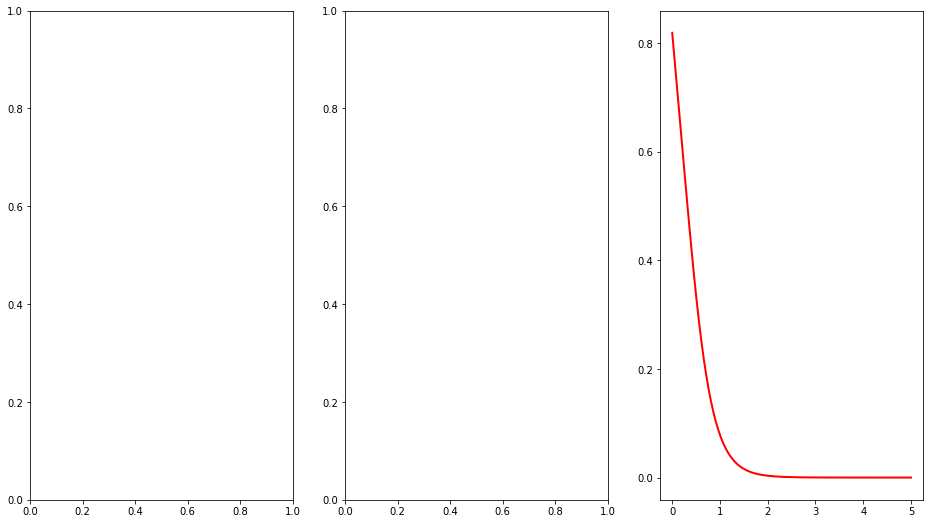

In [119]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16,9))


ax3.plot(Scut,sol1,color='r',linewidth=2,label='Analytics')
ax3.plot(Scut,f1cut,color='g',linewidth=2,label='Numerics',linestyle='--')
ax3.set_title(r'Time to expiry: $\tau={0:.2f}$'.format(t1),fontsize=20)

ax2.plot(Scut,sol2,color='r',linewidth=2,label='Analytics')
ax2.plot(Scut,f2cut,color='g',linewidth=2,label=r'Numerics',linestyle='--')
ax2.set_title(r'Time to expiry: $\tau={0:.2f}$'.format(t2),fontsize=20)
ax2.set_xlabel("Stock Price (in currency units)",size=18)

ax1.plot(Scut,sol3,color='r',linewidth=2,label='Analytics')
ax1.plot(Scut,f3cut,color='g',linewidth=2,label='Numerics',linestyle="--")
ax1.set_title(r'Time to expiry: $\tau={0:.2f}$'.format(t3),fontsize=20)
ax1.set_ylabel("Option Price (in currency units)", size=18)

Smax = Scut[-1]
fmax = np.amax(f3cut)
for ax in fig.axes:
    ax.hlines(strike_price,-1,Smax*(1+0.05),color='k',linewidth=1,label=r'$K$ (strike price)')
    ax.plot(Scut,np.where(strike_price - Scut>0,strike_price - Scut,0),color='k',linestyle=':'
            ,linewidth=2,label="Expiry Condition")
    ax.set_xlim((-.05,Smax*(1+0.05)))
    ax.set_ylim((-0.01,fmax*(1+0.25)))
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.legend(fontsize=14,loc='center right')

    

### conservation?

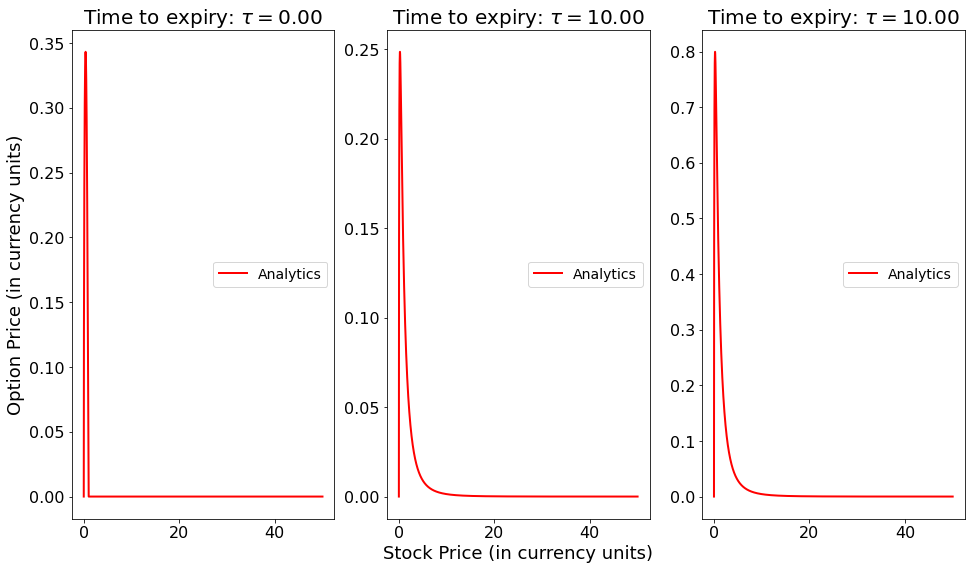

In [101]:
Ns, Nt = 8000,150
Tc = 10.
Sm = 50
tau = np.linspace(0,Tc,Nt)
S = np.linspace(0,Sm,Ns)

Max_S_to_Plot = Sm
time1,time2,time3 = T,T/2.,0. 
ind1,ind2,ind3 = nearest_ind(tau,time1),nearest_ind(tau,time2),nearest_ind(tau,time3)


t1,t2,t3 = tau[ind1],tau[ind2],tau[ind3]
# f1,f2,f3 = f[ind1],f[ind2],f[ind3]
exSol = np.vectorize(lambda s,t: option_test_2.BSM_sol(t,s))
cut = nearest_ind(S,Max_S_to_Plot)+1
# Scut,f1cut,f2cut,f3cut = S[:cut],f1[:cut],f2[:cut],f3[:cut]
Scut = S[:cut]
sol1,sol2,sol3 = exSol(Scut,t1), exSol(Scut,t2), exSol(Scut,t3)




fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16,9))

R = 2*r/(sigma*sigma)
alpha = (1-R)/2
beta = -0.25*(1+R)*(1+R)
tauScale = sigma*sigma/2


u_sol1 = (sol1/strike_price)*( (Scut/strike_price)**(-alpha) )*np.exp(-beta*time1*tauScale)
# u_f1cut = (f1cut/strike_price)*( (Scut/strike_price)**(-alpha) )*np.exp(-beta*time1*tauScale)
ax3.plot(Scut,u_sol1,color='r',linewidth=2,label='Analytics')
# ax3.plot(Scut,u_f1cut,color='g',linewidth=2,label='Numerics',linestyle='--')
ax3.set_title(r'Time to expiry: $\tau={0:.2f}$'.format(t1),fontsize=20)

u_sol2 = (sol2/strike_price)*( (Scut/strike_price)**(-alpha) )*np.exp(-beta*time2*tauScale)
# u_f2cut = (f2cut/strike_price)*( (Scut/strike_price)**(-alpha) )*np.exp(-beta*time2*tauScale)
ax2.plot(Scut,u_sol2,color='r',linewidth=2,label='Analytics')
# ax2.plot(Scut,u_f2cut,color='g',linewidth=2,label=r'Numerics',linestyle='--')
ax2.set_title(r'Time to expiry: $\tau={0:.2f}$'.format(t2),fontsize=20)
ax2.set_xlabel("Stock Price (in currency units)",size=18)

u_sol3 = (sol3/strike_price)*( (Scut/strike_price)**(-alpha) )*np.exp(-beta*time3*tauScale)
# u_f3cut = (f3cut/strike_price)*( (Scut/strike_price)**(-alpha) )*np.exp(-beta*time3*tauScale)
ax1.plot(Scut,u_sol3,color='r',linewidth=2,label='Analytics')
# ax1.plot(Scut,u_f3cut,color='g',linewidth=2,label='Numerics',linestyle="--")
ax1.set_title(r'Time to expiry: $\tau={0:.2f}$'.format(t3),fontsize=20)
ax1.set_ylabel("Option Price (in currency units)", size=18)

Smax = Scut[-1]
# fmax = np.amax(f3cut)
for ax in fig.axes:
#     ax.hlines(strike_price,-1,Smax*(1+0.05),color='k',linewidth=1,label=r'$K$ (strike price)')
#     ax.plot(Scut,np.where(strike_price - Scut>0,strike_price - Scut,0),color='k',linestyle=':'
#             ,linewidth=2,label="Expiry Condition")
#     ax.set_xlim((-.05,Smax*(1+0.05)))
#     ax.set_ylim((-0.01,fmax*(1+0.25)))
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.legend(fontsize=14,loc='center right')

    

In [106]:
# fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16,9))
dS = Scut[1]-Scut[0]

uSolInt_of_t = []
u_fInt_of_t = []
for i,t in enumerate(tau):
    print(t)
#     fcut = f[i,:cut]
    sol = exSol(Scut,t)
#     u_sol = (sol/strike_price)*( (Scut/strike_price)**(-alpha) )*np.exp(-beta*t*tauScale)
    u_sol = (sol/strike_price)*( (Scut/strike_price)**(-alpha) )*np.exp(-t*tauScale*(1+beta))
#     u_fcut = (fcut/strike_price)*( (Scut/strike_price)**(-alpha) )*np.exp(-beta*t*tauScale)    

    uSolInt = np.trapz(u_sol,dx=dS)
#     u_fInt = np.trapz(u_fcut,dx=dS)
    
    uSolInt_of_t.append(uSolInt)
#     u_fInt_of_t.append(u_fInt)


0.0
0.06711409395973154
0.1342281879194631
0.20134228187919462
0.2684563758389262
0.33557046979865773
0.40268456375838924
0.4697986577181208
0.5369127516778524
0.6040268456375839
0.6711409395973155
0.738255033557047
0.8053691275167785
0.87248322147651
0.9395973154362416
1.0067114093959733
1.0738255033557047
1.1409395973154361
1.2080536912751678
1.2751677852348993
1.342281879194631
1.4093959731543624
1.476510067114094
1.5436241610738255
1.610738255033557
1.6778523489932886
1.74496644295302
1.8120805369127517
1.8791946308724832
1.9463087248322148
2.0134228187919465
2.0805369127516777
2.1476510067114094
2.214765100671141
2.2818791946308723
2.348993288590604
2.4161073825503356
2.4832214765100673
2.5503355704697985
2.61744966442953
2.684563758389262
2.751677852348993
2.8187919463087248
2.8859060402684564
2.953020134228188
3.0201342281879193
3.087248322147651
3.1543624161073827
3.221476510067114
3.2885906040268456
3.3557046979865772
3.422818791946309
3.48993288590604
3.557046979865772
3.6241

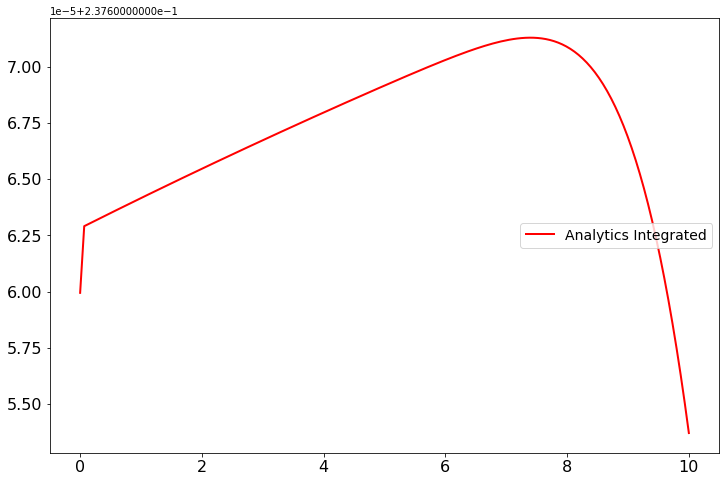

In [108]:
fig, ax = plt.subplots(figsize=(12,8))
def fitfunc(t,a,b):
#     a = uSolInt_of_t[0]
    return a*np.exp(b*t)
from scipy.optimize import curve_fit as cf

uSolInt_of_t = np.array(uSolInt_of_t)
ax.plot(tau,uSolInt_of_t,color='r',linewidth=2,label='Analytics Integrated')
# ax.plot(tau,u_fInt_of_t,color='g',linewidth=2,label='Numerics Integrated',linestyle='--')
# ax.set_title(r'Time to expiry: $\tau={0:.2f}$'.format(tTup[i]),fontsize=20)

# uSolInt_flat = uSolInt_of_t*np.exp(-tauScale*tau)
# ax.plot(tau,uSolInt_flat,color='r',linewidth=2,label='Analytics with exp Tau factor,')

# test = uSolInt_of_t[0] + r*tau/10
# test = uSolInt_of_t[0]*np.exp(r*tau/10)
# slope = (uSolInt_of_t[-1]-uSolInt_of_t[0])/tau[-1]
# print(slope,np.exp(-(R-1)*(R-1)/4))
# test = uSolInt_of_t[0] + slope*tau
# res = linregress(tau,uSolInt_of_t) #x and y are arrays or lists.
# test = res[1] + res[0]*t


# res = cf(fitfunc,tau,uSolInt_of_t)
# a,b = res[0]
# test = a*np.exp(b*tau)
# ax.plot(tau,test,color='k',linewidth=2,label='Fit: b={0:.5f}'.format(b))

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.legend(fontsize=14,loc='center right')


In [ ]:
#b=0.04492 || Sm = 100, Ns = 10000, T = 20, Nt = 200; r=0.1, sigma=0.3
#b=0.04501 || Sm = 50, Ns = 5000, T = 10, Nt = 100; r=0.1, sigma=0.3


In [89]:
tauScale

0.045

In [73]:
int1 = fInt(10,1)
int2 = np.trapz(f(x,1),dx=dX)
print(int1,int2)

648.2838427652147 648.2841938908139


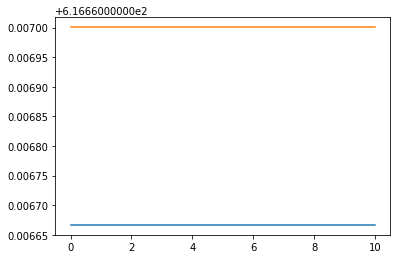

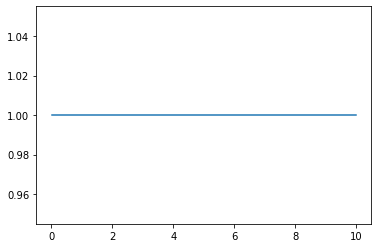

In [83]:
def f(x,t):
    return (2*x*x - x)*np.exp(0.05*t)
def fInt(x,t):#from 0 to x
    return ((2/3)*x*x*x - 0.5*x*x)

x = np.linspace(0,10,1000)
dX = x[1] - x[0]
t = np.linspace(0,10,1000)
y = [f(x,tt) for tt in t]

yIntAn = np.array([fInt(x[-1],tt) for tt in t])
yIntNum = np.array([np.trapz(yt,dx=dX)/np.exp(0.05*t[i]) for i,yt in enumerate(y)])


plt.plot(t,yIntAn)
plt.plot(t,yIntNum)
plt.show()
plt.plot(t[1:],yIntAn[1:]/(yIntNum[1:]))

0.01001001001001001

In [ ]:
strike_price = 1.
T = 2
sigma = 0.3
r = 0.1
#European_Long_Call(K,T,sigma,r)
cons_test = cons_test_op(strike_price,T,sigma,r)


In [ ]:
# cons_test.X_MIN = 0.0
# cons_test.X_MAX = 5
Ns, Nt = 380,5000
tau,S,f = Explicit_BSM(cons_test,Ns,Nt)

In [ ]:
X = S
S = cons_test.SofX(X)

In [ ]:
Max_S_to_Plot = 5
time1,time2,time3 = T,T/2.,0. 
ind1,ind2,ind3 = nearest_ind(tau,time1),nearest_ind(tau,time2),nearest_ind(tau,time3)


t1,t2,t3 = tau[ind1],tau[ind2],tau[ind3]
f1,f2,f3 = f[ind1],f[ind2],f[ind3]
# exSol = np.vectorize(lambda s,t: option_test_2.BSM_sol(t,s))
cut = nearest_ind(S,Max_S_to_Plot)+1
Scut,f1cut,f2cut,f3cut = S[:cut],f1[:cut],f2[:cut],f3[:cut]
# sol1,sol2,sol3 = exSol(Scut,t1), exSol(Scut,t2), exSol(Scut,t3)

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16,9))


# ax3.plot(Scut,sol1,color='r',linewidth=2,label='Analytics')
ax3.plot(Scut,f1cut,color='g',linewidth=2,label='Numerics',linestyle='--')
ax3.set_title(r'Time to expiry: $\tau={0:.2f}$'.format(t1),fontsize=20)

# ax2.plot(Scut,sol2,color='r',linewidth=2,label='Analytics')
ax2.plot(Scut,f2cut,color='g',linewidth=2,label=r'Numerics',linestyle='--')
ax2.set_title(r'Time to expiry: $\tau={0:.2f}$'.format(t2),fontsize=20)
ax2.set_xlabel("Stock Price (in currency units)",size=18)

# ax1.plot(Scut,sol3,color='r',linewidth=2,label='Analytics')
ax1.plot(Scut,f3cut,color='g',linewidth=2,label='Numerics',linestyle="--")
ax1.set_title(r'Time to expiry: $\tau={0:.2f}$'.format(t3),fontsize=20)
ax1.set_ylabel("Option Price (in currency units)", size=18)

Smax = Scut[-1]
fmax = np.amax(f3cut)
for ax in fig.axes:
    ax.hlines(strike_price,-1,Smax*(1+0.05),color='k',linewidth=1,label=r'$K$ (strike price)')
    ax.plot(Scut,np.where(strike_price - Scut>0,strike_price - Scut,0),color='k',linestyle=':'
            ,linewidth=2,label="Expiry Condition")
    ax.set_xlim((-.05,Smax*(1+0.05)))
    ax.set_ylim((-0.01,fmax*(1+0.25)))
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.legend(fontsize=14,loc='center right')

    

In [ ]:
# time1,time2,time3 = T,T/2.,0. 
# ind1,ind2,ind3 = nearest_ind(tau,time1),nearest_ind(tau,time2),nearest_ind(tau,time3)
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16,9))

R = 2*r/(sigma*sigma)
alpha = (1-R)/2
beta = -0.25*(1+R)*(1+R)

# f1,f2,f3 = f[ind1],f[ind2],f[ind3]
dS = S[1]-S[0]
# df_dS_1 = np.gradient(f1cut,dS)
# df_dS_2 = np.gradient(f2cut,dS)
# df_dS_3 = np.gradient(f3cut,dS)

# Max_S_to_Plot = 2
# cut = nearest_ind(S,Max_S_to_Plot)+1
# Scut,f1,f2,f3,df_dS_1,df_dS_2,df_dS_3 = S[:cut],f1[:cut],f2[:cut],f3[:cut],df_dS_1[:cut],df_dS_2[:cut],df_dS_3[:cut]

fTup = (f3cut,f2cut,f1cut)
# dfTup = (df_dS_3,df_dS_2,df_dS_1)
tTup = (time3,time2,time1)

# eps = 1e-16 #to prevent divergences
# dPlus1 = ( 1/(sigma*np.sqrt(t1) + eps) )*( np.log(Scut/strike_price + eps) + (r+sigma*sigma/2)*t1 )
# dPlus2 = ( 1/(sigma*np.sqrt(t2) + eps) )*( np.log(Scut/strike_price + eps) + (r+sigma*sigma/2)*t2 )
# dPlus3 = ( 1/(sigma*np.sqrt(t3) + eps) )*( np.log(Scut/strike_price + eps) + (r+sigma*sigma/2)*t3 )
# N = lambda s: norm.cdf(s)
# dSolTup = (N(dPlus3)-1,N(dPlus2)-1,N(dPlus1)-1)
solTup = (sol3,sol2,sol1)

# ax1.plot(Scut,sol3,color='r',linewidth=2,label='Analytics')
# ax1.set_title(r'Time to expiry: $\tau={0:.2f}$'.format(t3),fontsize=20)
# ax1.set_ylabel("Option Price (in currency units)", size=18)
# Smax = Scut[-1]
# fmax = np.amax(f3)
for i,ax in enumerate(fig.axes):
    t,f_i,df_dS = tTup[i],fTup[i],dfTup[i]
    sol,dSol = solTup[i],dSolTup[i]

#     currentNum = ((Scut/strike_price)**(-alpha))*np.exp(-beta*0.5*sigma*sigma*t)*( (Scut/strike_price)*df_dS - alpha*f_i/strike_price )
#     currentSol = ((Scut/strike_price)**(-alpha))*np.exp(-beta*0.5*sigma*sigma*t)*( (Scut/strike_price)*dSol - alpha*sol/strike_price )
    
    currentNum = (f_i/strike_price)*np.exp(-alpha*np.log(Scut/strike_price)-beta*0.5*sigma*sigma*t)
    currentSol = (exSol(Scut,t)/strike_price)*np.exp(-alpha*np.log(Scut/strike_price)-beta*0.5*sigma*sigma*t)
    
    integNum = np.trapz(currentNum,dx=dS)
    integSol = np.trapz(currentSol,dx=dS)

    ax.plot(Scut,currentNum,color='g',linewidth=2,label='Numerics',linestyle="--")
    ax.plot(Scut,currentSol,color='r',linewidth=2,label='Analytics')
    ax.hlines(integNum,-1,Smax*(1+0.05),color='g',linewidth=2,linestyle=':',label=r'integ Num$={0:.2f}$'.format(integNum))
    ax.hlines(integSol,-1,Smax*(1+0.05),color='r',linewidth=2,linestyle=':',label=r'integ Sol$={0:.2f}$'.format(integSol))

    ax.set_xlim((-.05,Smax*(1+0.05)))
#     ax.set_ylim((-0.01,fmax*(1+0.25)))
    ax.set_title(r'Time to expiry: $\tau={0:.2f}$'.format(t),fontsize=20)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.legend(fontsize=14,loc='center right')


In [ ]:
np.log(Sint/strike_price), alpha

In [ ]:
dS = 1e-4
t = 0
u0 = np.exp(-(R-1)*(R-1)/4)
Sint = np.arange(dS,5,dS)
u = np.append(np.array([u0]),(exSol(Sint,t)/strike_price)*np.exp(-beta*0.5*sigma*sigma*t)*(Sint/strike_price)**(-alpha))
integ = np.trapz(u,dx=dS)
plt.plot(np.append(np.array([0.0]),Sint),u)
# plt.plot(Sint,np.exp(-alpha*np.log(Sint/strike_price)))
# plt.plot(Sint,)

print(integ,u[0])

In [ ]:
Conservation = Int/Int[0] - 1
plt.plot(tau,Conservation)


In [ ]:
def sqr(x):
    return x**2
def anyl(xf,x0):
    return (xf**3)/3 - (x0**3)/3
X = np.linspace(0,10,10000)
y = sqr(X)
dX = X[1]-X[0]
print(np.trapz(y,dx=dX),anyl(X[-1],X[0]))

In [ ]:
# Xleft = np.linspace(-10,-1,250)
# Xright = np.linspace(0.1,np.log(100),250)
# X = np.append(Xleft,Xright)

X = np.linspace(-1,0.99999,1000)
# X = np.linspace(-25,np.log(1000),1000)


T = np.linspace(0,100,200)
exSol = np.vectorize(lambda s,t: option_test_2.BSM_sol(t,s))
# R = 2*r/(sigma*sigma)
# alpha = (1-R)/2
# beta = -0.25*(1+R)*(1+R)

S = option_test_1.SofX(X)#np.exp(X)
# S = np.linspace(0,10,100)
# u = np.array([exSol(S,tt)/strike_price for tt in T])
# u = np.array([(exSol(S,tt)/strike_price)*np.exp(-alpha*X-beta*0.5*sigma*sigma*tt) for tt in T])
u = np.array([(exSol(S,tt)/strike_price)*np.exp(-alpha*np.arctanh(X)-beta*0.5*sigma*sigma*tt) for tt in T])

Int, Int2 = [],[]
dX = (X[1] - X[0])
dT = T[1] - T[0]
for i,u_x in enumerate(u):
# # #     F_t = np.exp(-beta*0.5*sigma*sigma*T[i])
    integ = np.trapz(u_x,dx=dX)
    Int.append(integ)
#     Int.append(np.trapz(u_x,dx=dX) - ((R+1)/2)*np.exp(((R+1)/2)*X[-1])*dT )
    integ2 = np.trapz(u_x,dx=dX)
    Int2.append(integ2*np.exp(beta*0.5*sigma*sigma*T[i]))


In [ ]:
m = (Int[-1]-Int[0])/T[-1]
print(m, m/Int[0])
# plt.plot(T,Int/Int[0])
# plt.plot(T,m*T/Int[0] + 1)
# plt.plot(X,u[ti])
# plt.plot(S,u[ti])
m = (Int2[-1]-Int2[0])/T[-1]
print(m, m/Int2[0])
plt.plot(T,Int2/Int2[0],linestyle='--')
plt.plot(T,m*T/Int2[0] + 1,linestyle='--')

# plt.plot(T,np.exp(-beta*0.5*sigma*sigma*T),color='k',linestyle=':')

In [ ]:
print(Int[0],Int2[0],Int[-1],Int2[-1],Int2[-1]/Int2[0],Int[-1]/Int[0])

In [ ]:
import time
from IPython import display


fig,ax = plt.subplots()
# rat0 =  np.where(u[1]>0.1,u[0]/u[1],1.)
for ti in range(0,200):
    ax.plot(X,u[ti])
    ax.set_yscale('symlog',linthresh=0.1)
#     rat = np.where(u[ti-1]>0.1,u[ti]/u[ti-1],1.)
#     ax.plot(X,rat)
#     ax.plot(X,np.exp(r*(T[ti-1]-T[ti]))*rat)

#     display.display(plt.gcf())
#     time.sleep(0.1)
#     if(ti<49):
#         display.clear_output(wait =True)
#         if(ti>1):
#             plt.cla()
#             ax.plot(X,rat0,color='k',zorder=9999)
     

In [ ]:
np.exp((R-1)*(R-1)/4)

In [ ]:
ConsLin = Int
# ConsExp = IntExp/IntExp[0]
# plt.plot(np.arange(0,50),ConsLin)
plt.plot(np.arange(0,50),np.log(ConsLin))


# UNFINISHED BELOW

## European Long Call using Non-Linear BSM

In [ ]:
strike_price = 1
sigma = 0.3
r = 0.1
T = 2
Ns, Nt = 250,500

#European_Long_Call(K,T,sigma,r)
option_test_4 = European_Long_Call_Non_Linear(strike_price,T,sigma,r)


In [ ]:
tau,S,f = Explicit_BSM(option_test_4,Ns,Nt)

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16,9))

Max_S_to_Plot = 100#1.5
time1,time2,time3 = T,T/2.,0
ind1,ind2,ind3 = nearest_ind(tau,time1),nearest_ind(tau,time2),nearest_ind(tau,time3)


t1,t2,t3 = tau[ind1],tau[ind2],tau[ind3]
f1,f2,f3 = f[ind1],f[ind2],f[ind3]
exSol = np.vectorize(lambda s,t: option_test_4.BSM_sol(t,s))
cut = nearest_ind(S,Max_S_to_Plot)+1
Scut,f1,f2,f3 = S[:cut],f1[:cut],f2[:cut],f3[:cut]
sol1,sol2,sol3 = exSol(Scut,t1), exSol(Scut,t2), exSol(Scut,t3)

ax3.plot(Scut,sol1,color='r',linewidth=2,label='Analytics')
ax3.plot(Scut,f1,color='g',linewidth=2,label='Numerics',linestyle='--')
ax3.set_title(r'Time to expiry: $\tau={0:.2f}$'.format(t1),fontsize=20)

ax2.plot(Scut,sol2,color='r',linewidth=2,label='Analytics')
ax2.plot(Scut,f2,color='g',linewidth=2,label=r'Numerics',linestyle='--')
ax2.set_title(r'Time to expiry: $\tau={0:.2f}$'.format(t2),fontsize=20)
ax2.set_xlabel("Stock Price (in currency units)",size=18)

ax1.plot(Scut,sol3,color='r',linewidth=2,label='Analytics')
ax1.plot(Scut,f3,color='g',linewidth=2,label='Numerics',linestyle="--")
ax1.set_title(r'Time to expiry: $\tau={0:.2f}$'.format(t3),fontsize=20)
ax1.set_ylabel("Option Price (in currency units)", size=18)


print(f3[-1])
Smax = Scut[-1]
print(Smax)
fmax = np.amax(f3)
for ax in fig.axes:
    ax.hlines(Smax-strike_price,-1,Smax*(1+0.05),color='k',linewidth=1,label=r'$S_{\mathrm{max}}-K$')
    ax.plot(Scut,np.where(Scut - strike_price>0,Scut - strike_price,0),color='k',linestyle=':'
            ,linewidth=2,label="Expiry Condition")
#     ax.set_xlim((-.05,Smax*(1+0.05)))
#     ax.set_ylim((-0.01,fmax*(1+0.25)))
#     ax.set_xlim((-.05,0.25))
#     ax.set_ylim((-0.01,0.08))
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.legend(fontsize=14,loc='center left')
    
#     for s in S:
#         if s/strike_price > 1:
#             ax.vlines(s,0,6,linestyle=':',color='k')
    

        

    

In [ ]:
tau_check = 2

ind = nearest_ind(tau,tau_check)
t = tau[ind]
ind_S = nearest_ind(S,strike_price*(1+0.5))

fplot = f[ind,ind_S:]
Splot = S[ind_S:]
dS_array = np.array([Splot[i+1] - Splot[i] for i in range(0,Splot.size-1)])
gradf = np.gradient(fplot,Splot)

fsol = exSol(Splot,t)
d1 = ( np.log(Splot/strike_price) + ( r+(0.5*sigma*sigma) )*t )/(sigma*np.sqrt(t))
NofD1 = norm.cdf(d1)

Error_Num = np.abs(fplot - (Splot - strike_price))/(Splot - strike_price)
Error_dF_Num = np.abs(gradf - 1)

Error_An = np.abs(fsol - (Splot - strike_price))/(Splot - strike_price)
Error_dF_An = np.abs(NofD1 - 1)

plt.figure(figsize=(12,10))

plt.plot(Splot-strike_price,Error_An,label=r'$\frac{|C^{\mathrm{An}} - (S-K)|}{(S-K)}$',color='r',linewidth=2)
plt.plot(Splot-strike_price,Error_dF_An,label=r'$\partial C/\partial S - 1$',color='r',linestyle='--',linewidth=2)

plt.plot(Splot-strike_price,Error_Num,label=r'$\frac{|C^{\mathrm{Num}} - (S-K)|}{(S-K)}$',color='g',linewidth=2)
plt.plot(Splot-strike_price,Error_dF_Num,label=r'$\partial C/\partial S - 1$',color='g',linestyle='--',linewidth=2)
     
plt.legend(loc='upper right',fontsize=16)
plt.title(r'Error at time $\tau={0:.2f}$'.format(t),size=20)
plt.xlabel(r'$S-K$',size=18)
plt.xticks(size=14)
plt.ylabel("Error Fraction",size=18)
plt.yticks(size=14)
# plt.ylim((-1e-3,0.01))

xlim = plt.xlim()
plt.hlines(0,*xlim,color='k',linestyle='--',zorder=0)
plt.xlim(xlim)

plt.show()


## European Long Put using Non-Linear BSM

In [ ]:
strike_price = 1.
T = 1
sigma = 0.3
r = 0.1
#European_Long_Call(K,T,sigma,r)
option_test_3 = European_Long_Put_Non_Linear(strike_price,T,sigma,r)


In [ ]:
option_test_2.X_MIN = 0.0
option_test_2.X_MAX = 10
Ns, Nt = 150,5000
tau,S,f = Explicit_BSM(option_test_3,Ns,Nt)

In [ ]:
print(f)

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16,9))
# t = T - tau
t = tau
ind1,ind2,ind3 = nearest_ind(t,T/1),nearest_ind(t,T/2),nearest_ind(t,0.)
# ind1,ind2,ind3 = 2,1,0


t1,t2,t3 = t[ind1],t[ind2],t[ind3]
f1,f2,f3 = f[ind1],f[ind2],f[ind3]
exSol = np.vectorize(lambda s,t: option_test_2.BSM_sol(t,s))
cut = nearest_ind(S,2)+1#S.size+1#
Scut,f1,f2,f3 = S[:cut],f1[:cut],f2[:cut],f3[:cut]
sol1,sol2,sol3 = exSol(Scut,t1), exSol(Scut,t2), exSol(Scut,t3)

print(Scut.size,S.size)

ax1.plot(Scut,f1)
ax1.plot(Scut,sol1)
ax1.set_title(r'$t={}$'.format(t1),fontsize=20)

# ax1.set_ylim((-ymax,ymax))

ax2.plot(Scut,f2)
ax2.plot(Scut,sol2)
ax2.set_title(r'$t={}$'.format(t2),fontsize=20)
# ax2.set_ylim((-ymax,ymax))

ax3.plot(Scut,f3)
ax3.plot(Scut,sol3)
ax3.set_title(r'$t={}$'.format(t3),fontsize=20)
# ax3.set_ylim((-ymax,ymax))

Smax = Scut[-1]
print(Smax)
# for ax in fig.axes:
#     ax.hlines(Smax-strike_price,-10,10,color='k',linestyle='--')
#     ax.plot(Scut,np.where(strike_price - Scut>0,strike_price - Scut,0),color='k',linestyle='--')
#     ax.set_xlim((-.05,Smax*(1+0.05)))
#     ax.set_ylim(-0.05,(Smax-strike_price)*(1+0.05))

# print(np.abs(sol1[-1] - f1[-1])/sol1[-1])


In [ ]:
a = np.logspace(1,2,100,base=3)
b = np.logspace(1,2,100,base=2)

In [ ]:
plt.plot(np.arange(100),a)
plt.plot(np.arange(100),b)